IMPORTS


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation 
from scipy.sparse import diags,identity
from matplotlib import rc
from IPython.display import HTML
from scipy.sparse.linalg import splu

rc('animation', html='html5') #display config

SET UP

constants, grid parameters and initial conditions

In [4]:
hbar = 1
c = 1
m = 1
XMIN = -35
XMAX = 35
dx = 0.01
N = int((XMAX-XMIN)/dx)
X = np.linspace(XMIN,XMAX, N)
x_0 = -4 #wave packet starting position
k_0 = 3 #starting momentum 
sigma = .5
dt = 0.002


WAVE PACKET FUNCTION

In [6]:
def gaussian_wave_packet(X):
    psi = np.exp(-(X-x_0)**2/(2*sigma**2)+1J*k_0*(X-x_0))
    psi /= np.sqrt(np.sum(np.abs(psi)**2) * dx)
    return psi



POTENTIAL FUNCTIONS

In [8]:
def free_particle(x):
    return 0*x

def V_step(x,x0,vmax):
    return vmax*np.heaviside(x-x0,1/2)

def V_well(x,x0,w,vmax):
   return vmax*(1-(np.heaviside(x-x0+w/2,1/2)-np.heaviside(x-x0-w/2,1/2)))

def V_barrier(x,x0,w,vmax):
    return vmax*(np.heaviside(x-x0+w/2,1/2)-np.heaviside(x-x0-w/2,1/2))

def build_H(x,V):
    alpha = hbar**2/(2*m*dx**2)

    main_diagonal = 2*alpha+V
    off_diagonal = -alpha*np.ones(N-1)

    H = diags(diagonals=[off_diagonal, main_diagonal, off_diagonal], offsets=[-1, 0, 1], format = 'csc')
    return H
    
def V_slope(x0,vmax,x1):
    V = []
    m = -vmax/(x0-x1)
    for i in X:    
        if i <x0:
            V.append(0)
        elif 0<i<x1:
            V.append(m*i)
        else:
            V.append(vmax)
            
    return np.array(V)

#V = V_slope(0,10,5)
#V= X**2 
V = free_particle(X)
#V = V_step(X,0,10)
#V = V_well(X,0,4,500)
#V= V_barrier(X,0,1,10)


In [9]:

I = identity(N, format = 'csc')    
H = build_H(X,V)

def CN(x,Nt):
    psi = gaussian_wave_packet(x)
    A = I+1j*dt/(2*hbar)*H
    B = I-1j*dt/(2*hbar)*H
    A_lu = splu(A)
    psi_tot = []
    store_every = 5
    for i in range(Nt):
        rhs = B @ psi          
        psi = A_lu.solve(rhs)
        if i % store_every == 0:
            psi_tot.append(psi.copy())
        
        
    return psi_tot
   


/var/folders/xj/bm41nlsj0898tm8yg5ymjvbr0000gn/T/ipykernel_71230/2604357819.py:4: RuntimeWarning: invalid value encountered in divide
  return V / np.max(V) * 1.5*np.max(np.abs(psi[0])**2)


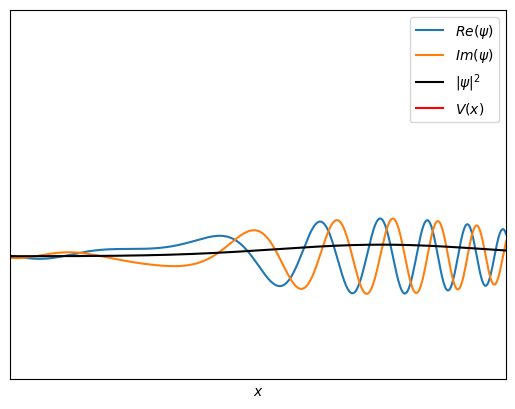

In [10]:
psi = CN(X,1500)

def V_plot_fit(V):
    return V / np.max(V) * 1.5*np.max(np.abs(psi[0])**2)

V_plot = V_plot_fit(V)
fig, ax = plt.subplots()


line_Re, = ax.plot(X, np.real(psi[0]), label=r"$Re(\psi)$")
line_Im, = ax.plot(X, np.imag(psi[0]), label=r"$Im(\psi)$")
line_prob, = ax.plot(X, np.abs(psi[0])**2, color='black', label=r"$|\psi|^2$")


ax.plot(X, V_plot, color='red', label=r"$V(x)$")

ax.set(xlim=[-10, 10], ylim=[-1,2])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"$x$")
ax.legend()

def update(frame):
    line_Re.set_ydata(np.real(psi[frame]))
    line_Im.set_ydata(np.imag(psi[frame]))
    line_prob.set_ydata(np.abs(psi[frame])**2)
    return line_Re, line_Im, line_prob
    
anim = FuncAnimation(fig, update, frames=len(psi), interval=30, blit=True)
anim.save("freeparticle.mp4", fps=25, dpi=150)

In [11]:
from IPython.display import Video

Video("freeparticle.mp4", embed=True)
